# Check on the files exported by Equivital File Manager
Plot and review measurements from equivital sensors as output by the Equivital Manager app.
(Every program produces different formated files and it's a pain.)

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import heartpy as hp

from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

## Definitions for data extraction

In [96]:
def eq_file_dets(eq_file_loc): # files output by kiosk have followed this filename formating
    file_name = eq_file_loc.split('/')[-1]
    a = file_name.split('.')[0].split('_') #eq_file_dets(f)
    File_dets={'Signal':a[1] ,
           'Participant':'NA', 
           'DevID':'NA' , 
           'Date':int(a[0][:6]) ,
           'Session':int(a[0][6:]),
           'FileName':file_name,
           'FullLoc':f}
    return File_dets

def min_dets(eq_file_loc): # for files output by the lab manager desktop app, so far
    filings = eq_file_loc.split('/')
    file_name = filings[-1]
    f = file_name.split('.')
    sig = f[-2][9:]
    
    if len(file_name.split(' '))==2:
        fileDate = file_name.split(' ')[0]
        Session = 'NA'
    else:
        fileDate = file_name.split('_')[0][:6]
        Session = file_name.split('_')[0][7:]
    if len(f[-2][9:].split('('))==2:
        sig = f[-2][9:].split('(')[0]
    
    File_dets={'Signal':sig, #f[-2].split('_')[-1],
       'ID':filings[-2], 
       'Date':fileDate ,
       'Session':Session,
       'FileName':file_name,
       'FileType':f[-1],
       'FullLoc':eq_file_loc}
    return File_dets

def eq_file_exct(eq_file_loc): # Files output by labManager
    dets=min_dets(eq_file_loc)
    #print(dets)
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
    # Extract according to signal type
    cols = list(V.columns )
    # find time colums
    time_c = [x for x in cols if x.lower().startswith('time')]
    if len(V.loc[0,'Date (M/d/yyyy)'])<20:
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)'],format='%m/%d/%Y')+ pd.to_timedelta(V.loc[:,time_c[0]]) 
        cols.remove('Date (M/d/yyyy)')    
        cols.remove(time_c[0])
        sig_df = pd.DataFrame(index = V.loc[:,'Time'],
                 columns = cols,
                 data = V.loc[:,cols].values)
    else:
        print('No Signal')
        sig_df = pd.DataFrame()
    return sig_df


In [3]:
# should convert for types and not change names of columns? .astype(float)

def eq_file_exct(eq_file_loc): # Files output by labManager
    dets=min_dets(eq_file_loc)
    #print(dets)
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
    # Extract according to signal type
    cols = V.columns 
    if dets['Signal'] in ['Indications','NewSummary']:
    #'Date (M/d/yyyy)', 'Time (HH:mm:ss.000)', 'Inter Beat Interval (ms)'
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)']+ V.loc[:,'Time (HH:mm:ss)']) 
        cols.remove(['Date (M/d/yyyy)','Time (HH:mm:ss)'])
    else:
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)']+ V.loc[:,'Time (HH:mm:ss.000)']) 
        cols.remove(['Date (M/d/yyyy)','Time (HH:mm:ss.000)'])
    sig_df = pd.DataFrame(index = V.loc[:,'Time'],
                     columns = cols,
                     data = V.loc[:,cols].values)
    return sig_df

    if dets['Signal'] == 'ECGmV':
    # Index(['Date (M/d/yyyy)', 'Time (HH:mm:ss.000)', 'ECG Lead 1', 'ECG Lead 2']
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)']+ V.loc[:,'Time (HH:mm:ss.000)']) 
        sig_df = V.loc[:,['ECG Lead 1', 'ECG Lead 2']].copy()
        sig_df.set_index(pd.to_datetime(V.loc[:,'Time']),inplace=True)
        return sig_df
    if dets['Signal'] == 'Belt':
    # 'Date (M/d/yyyy)', 'Time (HH:mm:ss.000)', 'Breathing Wave'
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)']+ V.loc[:,'Time (HH:mm:ss.000)']) 
        V.loc[:,'Breathing'] = V.loc[:,'Breathing Wave'].astype('int64')
        sig_df = V.loc[:,['Breathing']].copy()
        sig_df.set_index(V.loc[:,'Time'],inplace=True)
        return sig_df 
    if dets['Signal'].lower().startswith('acc'): # AccMG and AccmG_HR 
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)']+ V.loc[:,'Time (HH:mm:ss.000)']) 
        V.loc[:,'Z'] = V.loc[:,'Vertical Acc']
        V.loc[:,'Y'] = V.loc[:,'Lateral Acc']
        V.loc[:,'X'] = V.loc[:,'Longitudinal Acc']
        sig_df = V.loc[:,['X','Y','Z']].copy()
        sig_df.set_index(V.loc[:,'Time'],inplace=True)
        return sig_df 
    if dets['Signal'] == 'Indications': # 'HR Confidence', 'BR Confidence']
        V.loc[:,'Time'] = pd.to_datetime(df['Date (M/d/yyyy)'] + ' '+ df['Time (HH:mm:ss)'])
        V.loc[:,'HR Confidence'] = V.loc[:,'HR Confidence']
        V.loc[:,'BR Confidence'] = V.loc[:,'BR Confidence']
        sig_df = V.loc[:,['HR Confidence', 'BR Confidence']].copy()
        sig_df.set_index(V.loc[:,'Time'],inplace=True)
    if dets['Signal'] == 'NewSummary': # 'HR Confidence', 'BR Confidence']
#         ['Date (M/d/yyyy)', 'Time (HH:mm:ss)', 'Sensor ID',
#        'SEM File Designation', 'HR (bpm)', 'BR (rpm)',
#        'Skin Temperature - IR Thermometer (°C)', 'Body Position',
#        'Ambulation Status', 'Alert', 'PWI', 'Device Indications',
#        'Subject Indications']
        V.loc[:,'Time'] = pd.to_datetime(df['Date (M/d/yyyy)'] + ' '+ df['Time (HH:mm:ss)'])
        V.loc[:,'HR_bpm'] = V.loc[:,'HR (bpm)']
        V.loc[:,'BR_rpm'] = V.loc[:,'BR (rpm)']
        V.loc[:,'SkinTemp'] = V.loc[:,'Skin Temperature - IR Thermometer (°C)']
        V.loc[:,'Posture'] = V.loc[:,'Body Position']
        V.loc[:,'Ambulation'] = V.loc[:,'Ambulation Status']
        
        sig_df = V.loc[:,['HR_bpm','BR_rpm','SkinTemp','Posture','Ambulation']].copy()
        sig_df.set_index(V.loc[:,'Time'],inplace=True)
        return sig_df 

    else:
        print('Not familiar signal')
        return

# User output test

In [8]:
path = './Battery_tests/'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")):
            file_locs.append(os.path.join(root,file))
            print(file_locs[-1])
k=[]           
for f in file_locs:
    File_dets=min_dets(f)
    k.append(File_dets)
df_files=pd.DataFrame(data=k) #.sort_values('StartTime').reset_index(drop=True)
df_files

./Battery_tests/23012300_AccmG_HR.csv
./Battery_tests/23011900_RR(1).csv
./Battery_tests/23012004_EventComments.csv
./Battery_tests/23012007_ECGmV.csv
./Battery_tests/23011803_Indications(0).csv
./Battery_tests/23012301_EventComments.csv
./Battery_tests/23012301_Indications.csv
./Battery_tests/23012004_AccMG.csv
./Battery_tests/23012300_ECGmV.csv
./Battery_tests/23011900_Belt(1).csv
./Battery_tests/23012004_NewSummary.csv
./Battery_tests/23011900_NewSummary(1).csv
./Battery_tests/23011900_AccmG_HR(1).csv
./Battery_tests/23012003_RR.csv
./Battery_tests/23012007_Indications.csv
./Battery_tests/23012301_AccmG_HR.csv
./Battery_tests/23012300_EventComments.csv
./Battery_tests/23012003_NewSummary.csv
./Battery_tests/23012300_RR.csv
./Battery_tests/23011900_AccMG(1).csv
./Battery_tests/23012006_EventComments.csv
./Battery_tests/23012007_RR.csv
./Battery_tests/23011803_RR(0).csv
./Battery_tests/23011803_ECGmV(0).csv
./Battery_tests/23012007_AccmG_HR.csv
./Battery_tests/23012006_ECGmV.csv
./Bat

,Signal,ID,Date,Session,FileName,FileType,FullLoc
0,AccmG_HR,Battery_tests,230123,0,23012300_AccmG_HR.csv,csv,./Battery_tests/23012300_AccmG_HR.csv
1,RR(1),Battery_tests,230119,0,23011900_RR(1).csv,csv,./Battery_tests/23011900_RR(1).csv
2,EventComments,Battery_tests,230120,4,23012004_EventComments.csv,csv,./Battery_tests/23012004_EventComments.csv
3,ECGmV,Battery_tests,230120,7,23012007_ECGmV.csv,csv,./Battery_tests/23012007_ECGmV.csv
4,Indications(0),Battery_tests,230118,3,23011803_Indications(0).csv,csv,./Battery_tests/23011803_Indications(0).csv
...,...,...,...,...,...,...,...
59,Belt,Battery_tests,230123,1,23012301_Belt.csv,csv,./Battery_tests/23012301_Belt.csv
60,Belt,Battery_tests,230123,0,23012300_Belt.csv,csv,./Battery_tests/23012300_Belt.csv
61,Belt,Battery_tests,230120,4,23012004_Belt.csv,csv,./Battery_tests/23012004_Belt.csv
62,RR,Battery_tests,230120,4,23012004_RR.csv,csv,./Battery_tests/23012004_RR.csv


In [50]:
# select subset of files from a specific devices
print('Date: ' + str(df_files['Date'].unique()))
print('Session: ' + str(df_files['Session'].unique()))
print('Signal: ' + str(df_files['Signal'].unique()))
datum = '7' # this is a string of the number on the sensor unite
sub_files=df_files.loc[df_files['Session'] == datum,:]
sub_files

Date: ['230123' '230119' '230120' '230118']
Session: ['0' '4' '7' '3' '1' '6']
Signal: ['AccmG_HR' 'RR(1)' 'EventComments' 'ECGmV' 'Indications(0)' 'Indications'
 'AccMG' 'Belt(1)' 'NewSummary' 'NewSummary(1)' 'AccmG_HR(1)' 'RR'
 'AccMG(1)' 'RR(0)' 'ECGmV(0)' 'Belt' 'Indications(1)' 'EventComments(1)'
 'NewSummary(0)' 'ECGmV(1)' 'AccmG_HR(0)' 'Belt(0)' 'EventComments(0)'
 'AccMG(0)']


,Signal,ID,Date,Session,FileName,FileType,FullLoc
3,ECGmV,Battery_tests,230120,7,23012007_ECGmV.csv,csv,./Battery_tests/23012007_ECGmV.csv
14,Indications,Battery_tests,230120,7,23012007_Indications.csv,csv,./Battery_tests/23012007_Indications.csv
21,RR,Battery_tests,230120,7,23012007_RR.csv,csv,./Battery_tests/23012007_RR.csv
24,AccmG_HR,Battery_tests,230120,7,23012007_AccmG_HR.csv,csv,./Battery_tests/23012007_AccmG_HR.csv
28,Belt,Battery_tests,230120,7,23012007_Belt.csv,csv,./Battery_tests/23012007_Belt.csv
33,EventComments,Battery_tests,230120,7,23012007_EventComments.csv,csv,./Battery_tests/23012007_EventComments.csv
35,NewSummary,Battery_tests,230120,7,23012007_NewSummary.csv,csv,./Battery_tests/23012007_NewSummary.csv
57,AccMG,Battery_tests,230120,7,23012007_AccMG.csv,csv,./Battery_tests/23012007_AccMG.csv


In [13]:
# select subset of files based on the type of output file 
datafile_type = 'NewSummary'
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]
sub_files

,Signal,ID,Date,Session,FileName,FileType,FullLoc
10,NewSummary,Battery_tests,230120,4,23012004_NewSummary.csv,csv,./Battery_tests/23012004_NewSummary.csv
17,NewSummary,Battery_tests,230120,3,23012003_NewSummary.csv,csv,./Battery_tests/23012003_NewSummary.csv
30,NewSummary,Battery_tests,230120,6,23012006_NewSummary.csv,csv,./Battery_tests/23012006_NewSummary.csv
35,NewSummary,Battery_tests,230120,7,23012007_NewSummary.csv,csv,./Battery_tests/23012007_NewSummary.csv
46,NewSummary,Battery_tests,230123,1,23012301_NewSummary.csv,csv,./Battery_tests/23012301_NewSummary.csv
51,NewSummary,Battery_tests,230123,0,23012300_NewSummary.csv,csv,./Battery_tests/23012300_NewSummary.csv


In [58]:
df

,Date (M/d/yyyy),Time (HH:mm:ss.000),Lead Off alert,Belt Off alert,Low HR Confidence,HR Confidence,Low BR Confidence,BR Confidence,Low Battery Internal,Full Battery Internal,Low Battery External,Button Press Event,ECG Saturation,Fall Alarm,Apnea,Irregular rhythm HR,Broad Pulse Tachycardia,Heart rate high/low,Breathing rate high/low,ECG Breathing rate high/low
0,1/20/2023,23:00:08.726,Y,Y,Y,-1,Y,-1,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,Y,NaN,NaN
1,1/20/2023,23:00:13.726,Y,NaN,NaN,85,NaN,100,NaN,Y,NaN,NaN,Y,NaN,Y,NaN,NaN,Y,Y,NaN
2,1/20/2023,23:00:18.726,Y,NaN,NaN,85,NaN,100,NaN,Y,NaN,NaN,Y,NaN,NaN,NaN,NaN,Y,Y,NaN
3,1/20/2023,23:00:23.726,Y,NaN,NaN,85,NaN,100,NaN,Y,NaN,NaN,Y,NaN,NaN,NaN,NaN,Y,Y,NaN
4,1/20/2023,23:00:28.726,Y,NaN,NaN,97,NaN,100,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11169,1/21/2023,14:30:53.726,NaN,NaN,NaN,99,NaN,96,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11170,1/21/2023,14:30:58.726,NaN,NaN,NaN,93,NaN,96,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11171,1/21/2023,14:31:03.726,NaN,NaN,NaN,93,NaN,96,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11172,1/21/2023,14:31:08.726,NaN,NaN,NaN,93,NaN,96,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Indications ./Battery_tests/23012007_Indications.csv
Index(['Lead Off alert', 'Belt Off alert', 'Low HR Confidence',
       'HR Confidence', 'Low BR Confidence', 'BR Confidence',
       'Low Battery Internal', 'Full Battery Internal', 'Low Battery External',
       'Button Press Event', 'ECG Saturation', 'Fall Alarm', 'Apnea',
       'Irregular rhythm HR', 'Broad Pulse Tachycardia', 'Heart rate high/low',
       'Breathing rate high/low', 'ECG Breathing rate high/low'],
      dtype='object')
                        Lead Off alert Belt Off alert Low HR Confidence  \
Time                                                                      
2023-01-21 06:45:43.726            NaN            NaN               NaN   
2023-01-21 06:45:48.726            NaN            NaN               NaN   
2023-01-21 06:45:53.726            NaN            NaN               NaN   

                        HR Confidence Low BR Confidence BR Confidence  \
Time                                                

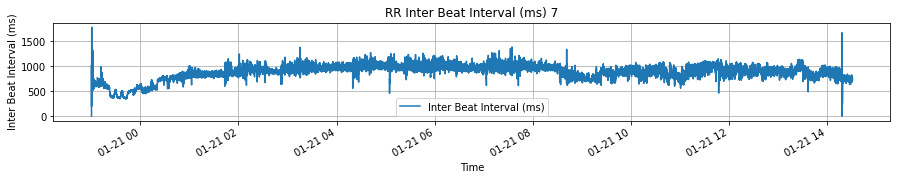



AccmG_HR ./Battery_tests/23012007_AccmG_HR.csv
Index(['Lateral Acc', 'Longitudinal Acc', 'Vertical Acc'], dtype='object')
                         Lateral Acc  Longitudinal Acc  Vertical Acc
Time                                                                
2023-01-21 06:45:36.367        830.7             417.3        -183.3
2023-01-21 06:45:36.371        838.5             425.1        -195.0
2023-01-21 06:45:36.375        842.4             421.2        -206.7


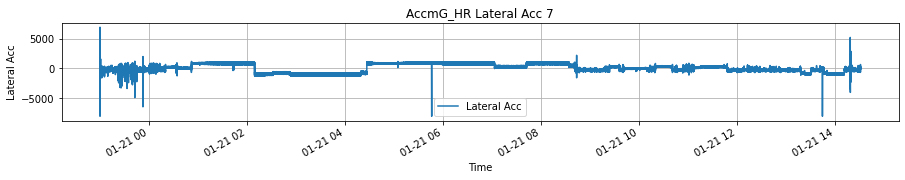

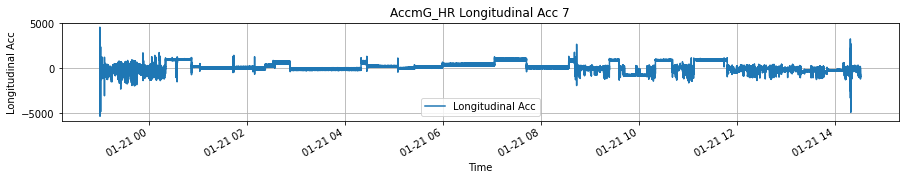

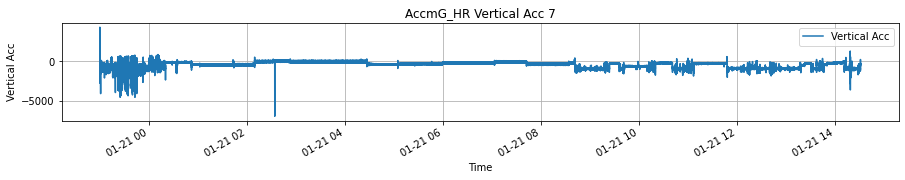



Belt ./Battery_tests/23012007_Belt.csv
Index(['Breathing Wave'], dtype='object')
                         Breathing Wave
Time                                   
2023-01-21 06:45:36.382             504
2023-01-21 06:45:36.421             504
2023-01-21 06:45:36.460             505


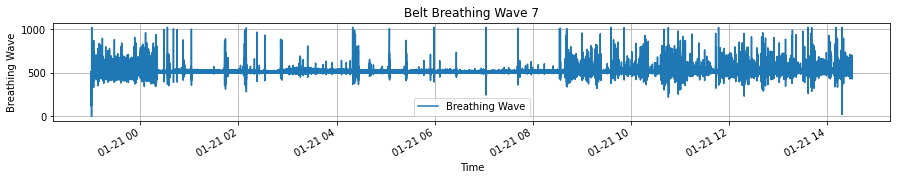



EventComments ./Battery_tests/23012007_EventComments.csv
No Signal


NewSummary ./Battery_tests/23012007_NewSummary.csv
Index(['Sensor ID', 'SEM File Designation', 'HR (bpm)', 'BR (rpm)',
       'Skin Temperature - IR Thermometer (°C)', 'Body Position',
       'Ambulation Status', 'Alert', 'PWI', 'Data Tag', 'Device Indications',
       'Subject Indications', 'Internal Battery Voltage'],
      dtype='object')
                     Sensor ID SEM File Designation HR (bpm) BR (rpm)  \
Time                                                                    
2023-01-21 06:45:43  3420415.0               Custom       61     17.0   
2023-01-21 06:45:48  3420415.0               Custom       64     17.0   
2023-01-21 06:45:53  3420415.0               Custom       56     17.0   

                    Skin Temperature - IR Thermometer (°C) Body Position  \
Time                                                                       
2023-01-21 06:45:43                                   36.3         

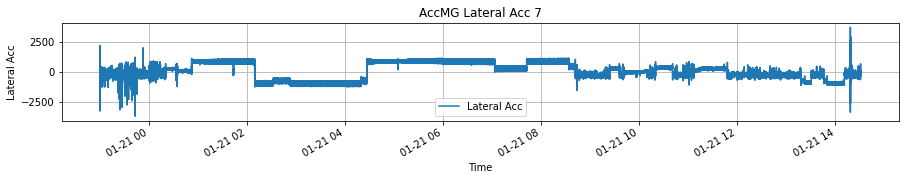

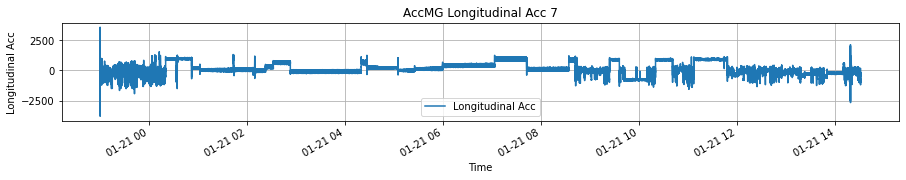

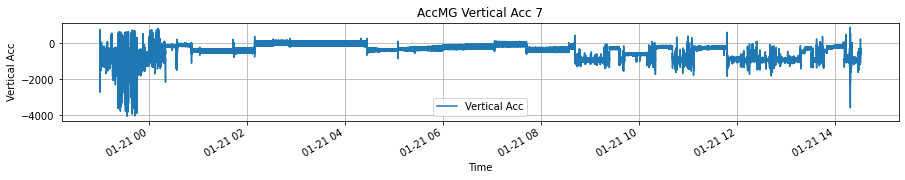

In [97]:
# make an initial reading of files in file subset to show contents formating

for c,row in sub_files.iloc[1:,:].iterrows():
    print('\n')
    print(row['Signal'] + ' ' + row['FullLoc'])  
 #   df =pd.read_csv(row['FullLoc'],header=0,low_memory=False)
    sig_df = eq_file_exct(row['FullLoc'])
    if not sig_df.empty:
        s = row['Signal']
        print(sig_df.columns)
        t = int(len(sig_df)/2) # grab signal from the middle of the recording, when it was being worn
        print(sig_df.iloc[t:t+3,:])
        for c in sig_df.columns:
            if sig_df[c].dtype in ['int64','float64']:
                sig_df.plot(y = c,figsize=(15,2))
                plt.xlabel('Time')
                plt.ylabel(c)
                plt.grid()
                plt.title(s + ' ' + c + ' ' + row['Session'])
                plt.show()

In [98]:
sig_num = sig_df.select_dtypes(include=['int64','float64'])

In [70]:
len(df.loc[0,'Date (M/d/yyyy)'])

27

# Plot sensor readings for specific interval of time

These run through files and plot their out puts within specific ranges of time


In [101]:
# if a single interval  
# notice no date specified, to match reading of these files
trial_times = pd.to_datetime(['2023-01-21 03:45:36.367','2023-01-21 03:55:36'])
# # and time stamps for markers of events (approx)

# trial_ends = pd.to_datetime(['13:24:00','13:30:09','13:38:34','13:43:27'])

Index(['Breathing Wave'], dtype='object')


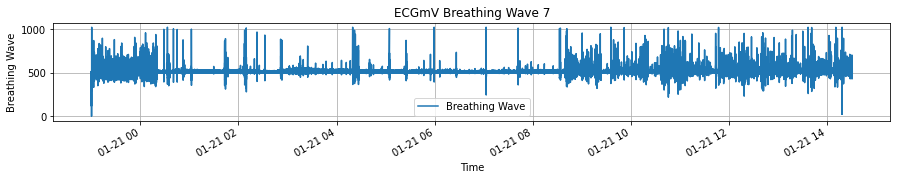

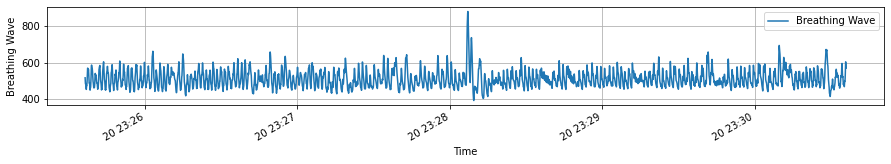

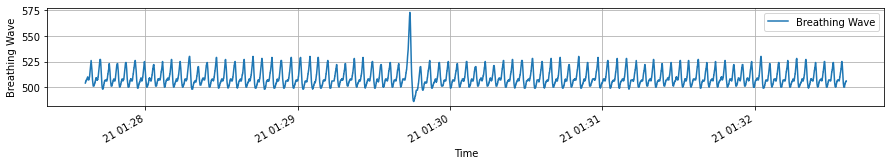

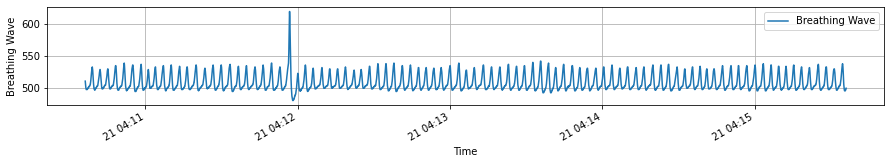

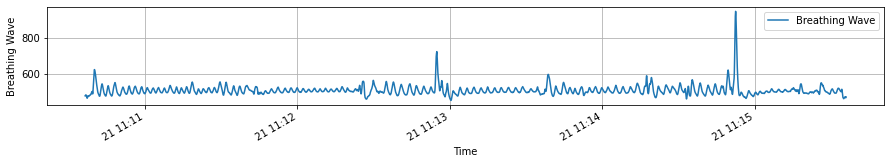

In [119]:
# plot the all the subfiles on the same region of time
datafile_type = 'Belt'
signal_interest = 'Breathing Wave'

#   df =pd.read_csv(row['FullLoc'],header=0,low_memory=False)
sig_df = eq_file_exct('./Battery_tests/23012007_Belt.csv')
print(sig_df.columns)
sig_df.plot(y = signal_interest,figsize=(15,2))
plt.xlabel('Time')
plt.ylabel(c)
plt.grid()
plt.title(s + ' ' + c + ' ' + row['Session'])
plt.show()

trial_times = pd.to_datetime(['2023-01-20 23:25:36.367','2023-01-20 23:30:36'])
a = sig_df.loc[trial_times[0]:trial_times[1]]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

trial_times = pd.to_datetime(['2023-01-21 01:27:36.367','2023-01-21 01:32:36'])
a = sig_df.loc[trial_times[0]:trial_times[1]]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

trial_times = pd.to_datetime(['2023-01-21 04:10:36.367','2023-01-21 04:15:36'])
a = sig_df.loc[trial_times[0]:trial_times[1]]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

trial_times = pd.to_datetime(['2023-01-21 11:10:36.367','2023-01-21 11:15:36'])
a = sig_df.loc[trial_times[0]:trial_times[1]]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

Index(['ECG Lead 1', 'ECG Lead 2'], dtype='object')


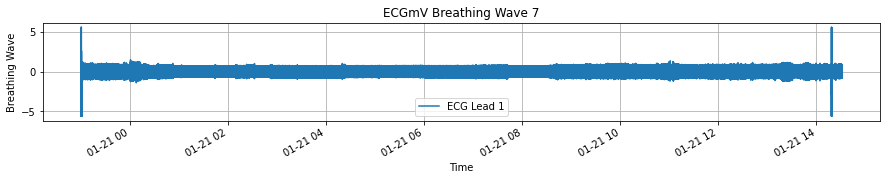

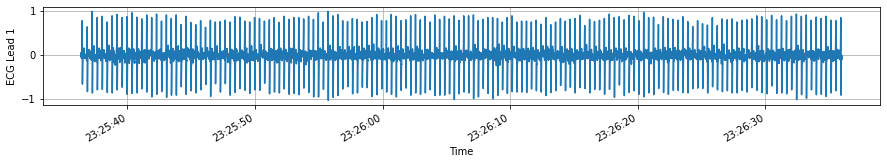

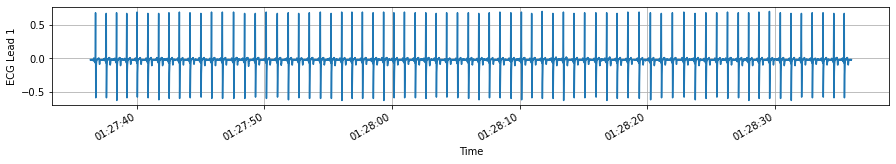

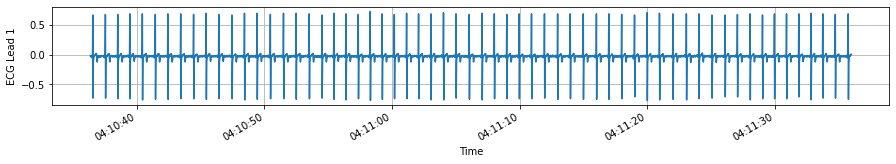

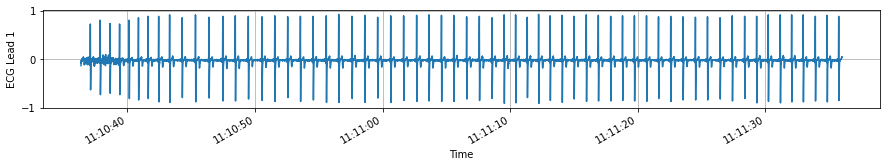

In [113]:
# plot the all the subfiles on the same region of time

signal_interest = 'ECG Lead 1'
#   df =pd.read_csv(row['FullLoc'],header=0,low_memory=False)
sig_df = eq_file_exct('./Battery_tests/23012007_ECGmV.csv')
print(sig_df.columns)
sig_df.plot(y = signal_interest,figsize=(15,2))
plt.xlabel('Time')
plt.ylabel(c)
plt.grid()
plt.title(s + ' ' + c + ' ' + row['Session'])
plt.show()

trial_times = pd.to_datetime(['2023-01-20 23:25:36.367','2023-01-20 23:26:36'])
a = sig_df.loc[trial_times[0]:trial_times[1],signal_interest]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

trial_times = pd.to_datetime(['2023-01-21 01:27:36.367','2023-01-21 01:28:36'])
a = sig_df.loc[trial_times[0]:trial_times[1],signal_interest]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

trial_times = pd.to_datetime(['2023-01-21 04:10:36.367','2023-01-21 04:11:36'])
a = sig_df.loc[trial_times[0]:trial_times[1],signal_interest]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

trial_times = pd.to_datetime(['2023-01-21 11:10:36.367','2023-01-21 11:11:36'])
a = sig_df.loc[trial_times[0]:trial_times[1],signal_interest]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

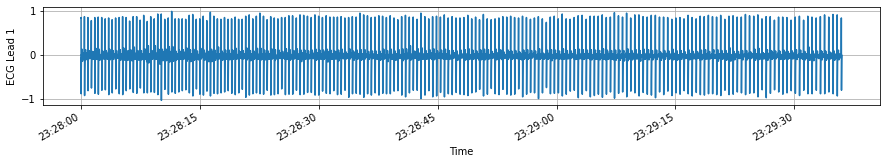

In [116]:
trial_times = pd.to_datetime(['2023-01-20 23:28:00.0','2023-01-20 23:29:36'])
a = sig_df.loc[trial_times[0]:trial_times[1],signal_interest]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

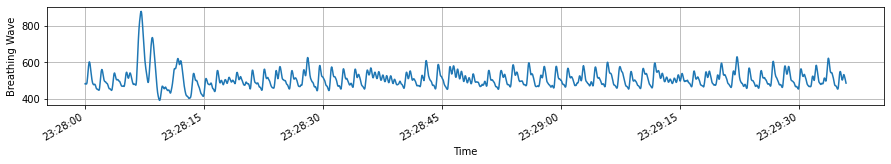

In [120]:
trial_times = pd.to_datetime(['2023-01-20 23:28:00.0','2023-01-20 23:29:36'])
a = sig_df.loc[trial_times[0]:trial_times[1],signal_interest]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

In [104]:
sig_df

,ECG Lead 1,ECG Lead 2
Time,,
2023-01-20 22:59:59.003,-5.19,-5.19
2023-01-20 22:59:59.007,-5.19,-5.19
2023-01-20 22:59:59.011,-5.19,-5.19
2023-01-20 22:59:59.015,-5.19,-5.19
2023-01-20 22:59:59.019,-5.19,-5.19
...,...,...
2023-01-21 14:31:13.710,0.00,-0.02
2023-01-21 14:31:13.714,0.00,-0.02
2023-01-21 14:31:13.718,-0.03,-0.02
